In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings('ignore')

# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [2]:
X, y = load_iris(return_X_y=True)

### 1. (*) Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

In [3]:
def PCA_svd(X: np.array) -> np.array:
    
    U,s,W = np.linalg.svd(X)
    
    return X@W

### 2. (*) Обучить любую модель классификации на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [4]:
X = X[:, :2]
X[:5]

array([[5.1, 3.5],
       [4.9, 3. ],
       [4.7, 3.2],
       [4.6, 3.1],
       [5. , 3.6]])

##### Зафиксируем на графике разброс до PCA

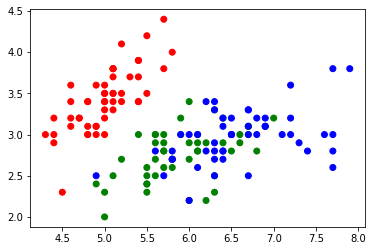

In [5]:
cmap = ListedColormap(['r', 'g', 'b'])

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
plt.show()

##### Просмотрим разброс после PCA

In [6]:
Z = PCA_svd(X)
Z[:5]

array([[-2.92451773, -5.45043081],
       [-2.97633119, -4.91441275],
       [-2.70684382, -5.00029964],
       [-2.66390038, -4.86555596],
       [-2.78977405, -5.49337426]])

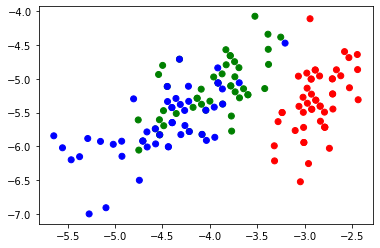

In [7]:
plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap=cmap)
plt.show()

##### На последнем графике видно, что тот же самый разброс перевернулся и немного повернулся на диагонали

In [8]:
def me_metrics(metrics, x1, x2):
    '''Манхеттенская метрика'''
    
    distance=0
    
    if metrics=='e':
        q = 2
        for i in range(len(x1)):
            distance += ((x1[i] - x2[i])**q)
        
    elif metrics=='m':
        q = 1
        for i in range(len(x1)):
            distance += (((x1[i] - x2[i])**2)**(1/2))**q
        
    return distance**(1/q)

In [9]:
def knn(x_train, y_train, x_test, metrics, k, nn):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            if nn == 1:
                distance = me_metrics(metrics, x, x_train[i])*1**i # w(i) = q^i
            elif nn == 2:
                distance = me_metrics(metrics, x, x_train[i])*(1/(i+1)**2) # w(i) = 1/i
            elif nn == 3:
                distance = me_metrics(metrics, x, x_train[i])*((k+1-i)/k) # w(i) = q^i
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [10]:
def accuracy(pred, y):
    '''Вычисление точности'''
    
    return (sum(pred == y) / len(y))

In [11]:
def get_graph(x_train, y_train, metrics, k, nn):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02
    if metrics == 'e':
        m = 'Эвклидовая'
    elif metrics == 'm':
        m = 'Манхеттенская'

    # Расчет пределов графика
    x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
    y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(x_train, y_train, np.c_[xx.ravel(), yy.ravel()], metrics, k, nn)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(8,6))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k} - {m} метрика")
    plt.show()

In [12]:
def pipeline(x_train, y_train, x_test, metrics, k, nn=1):
    
    if metrics == 'e':
        m = 'Эвклидовая'
    elif metrics == 'm':
        m = 'Манхеттенская'
        
    y_pred = knn(x_train, y_train, x_test, metrics, k, nn)
    
    print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f} - {m} метрика')
    
    get_graph(x_train, y_train, metrics, k, nn)

##### Научим модель до PCA

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Точность алгоритма при k = 5: 0.867 - Эвклидовая метрика


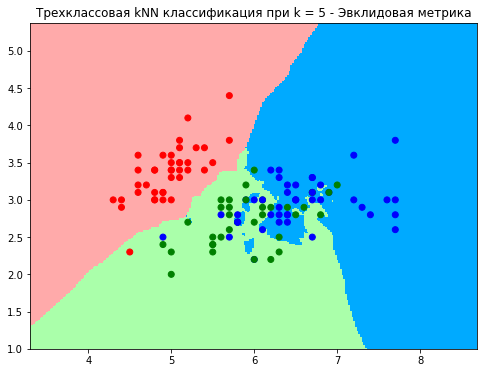

In [14]:
k = 5
nn = 1 # q^i

pipeline(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    metrics='e', # Эвклидова метрика
    k=k,
    nn=nn
)

##### Тепер научим после PCA

In [15]:
Z_train, Z_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, random_state=1)

Точность алгоритма при k = 5: 0.833 - Эвклидовая метрика


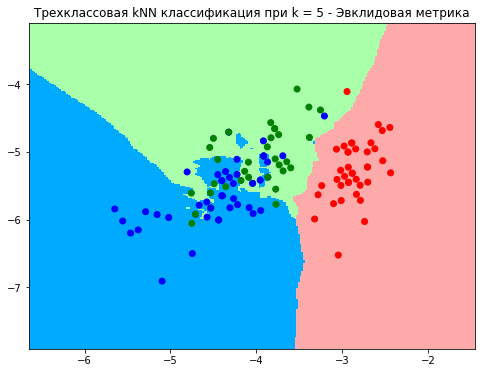

In [16]:
k = 5
nn = 1 # q^i

pipeline(
    x_train=Z_train,
    y_train=y_train,
    x_test=Z_test,
    metrics='e', # Эвклидова метрика
    k=k,
    nn=nn
)

Здесь так же оптимально будет использовать 5 соседей